Enter the population size or default 20 : 
Enter the crossover_rate or default 0.8 : 
Enter the mutation rate or default 0.3 :
Enter the mutation select rate or default 0.4 :
Enter the iteration times or default 1000 :
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
1-1
341.512366771698
1-2
442.46836709976196
1-3
380.570827960968
2-1
440.4984838962555
2-2
436.43347692489624
2-3
439.50372409820557
3-1
381.640673160553
3-2
467.356565952301
3-3
432.55248379707336
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
1-1
871.2816219329834
1-2
945.2984418869019
1-3
959.2133989334106
2-1
942.0156500339508
2-2
921.306568145752
2-3
921.1068980693817
3-1
811.039971113205
3-2
849.65420794487
3-3
900.9934031963348
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
1-1
1059.8707151412964
1-2
972.5603530406952
1-3
964.4009499549866
2-1
1010.8983008861542
2-2
995.8071041107178
2-3
1026.7649569511414
3-1
1190.711750984192
3-2
1105.1922569274902
3-3
1068.3333041667938
I=500:
3762.5398001670837
I=1000:
8121.927596092224
I=1500:
9394.590806007385


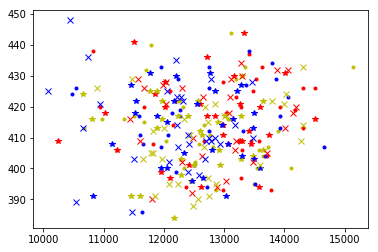

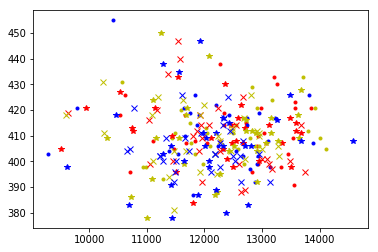

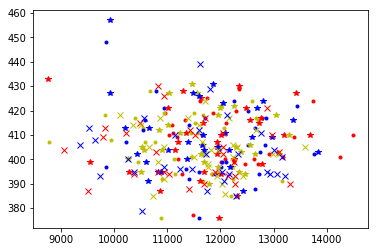

In [3]:
import numpy as np
import pandas as pd
import copy
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

INF = 999999999
pt_exc = pd.read_excel("Job_dataset.xlsx" , sheet_name="Processing Time" , index_col = "Time")#index_col把某一個column設定成index
ms_exc = pd.read_excel("Job_dataset.xlsx" , sheet_name="Machines Sequence" , index_col = "order")
job_pri_due_exe = pd.read_excel("Job_dataset.xlsx" , sheet_name="Priority and Due Date" , index_col="order")

num_job = pt_exc.shape[0]
num_machine = pt_exc.shape[1]
num_gene = num_job * num_machine

#put the data into list
pt = [list( map(int,pt_exc.iloc[i])) for i in range(num_job)]
ms = [list( map(int,ms_exc.iloc[i])) for i in range(num_job)]
job_pri_due = [list( map( int , job_pri_due_exe.iloc[i])) for i in range(num_job)]  

#set the initial parameter
population_size = int(input("Enter the population size or default 20 : ") or 20)
crossover_rate = float(input("Enter the crossover_rate or default 0.8 : ") or 0.8)
mutation_rate = float(input("Enter the mutation rate or default 0.3 :") or 0.3)
mutation_select_rate = float(input("Enter the mutation select rate or default 0.4 :") or 0.4)
iteration_times = int(input("Enter the iteration times or default 1000 :") or 1000)
num_mutation_gene = round( num_gene * mutation_select_rate)




#non dominated sort
#input->parent and child population
def non_dominated_sort(object_func_sol):
    S={}#use dictionary
    N={}
    Rank={}
    Front={}
    Front[0]=[]

    for p in range( len(object_func_sol) ):
        S[p]=[]
        N[p]=0
        for q in range( len(object_func_sol) ):
#if object function more than 2,then how to find???
            if (object_func_sol[p][0] <= object_func_sol[q][0] and object_func_sol[p][1] <= object_func_sol[q][1]):#we want as small as possiple
                if(object_func_sol[p][0] == object_func_sol[q][0] and object_func_sol[p][1] == object_func_sol[q][1]):
                    pass #do nothing
                else:
                    if(q not in S[p]):
                        S[p].append(q)
            elif (object_func_sol[p][0] >= object_func_sol[q][0] and object_func_sol[p][1] >= object_func_sol[q][1]):
                if(object_func_sol[p][0] == object_func_sol[q][0] and object_func_sol[p][1] == object_func_sol[q][1]):
                    pass
                else:
                    N[p]=N[p]+1
        #find first non dominated front
        if(N[p] == 0):
            Rank[p]=0
            if p not in Front[0]:
                Front[0].append(p)

                
    i = 0
    while (Front[i] != []):
        Q=[]
        for p in Front[i]:
            for q in S[p]:
                N[q]=N[q]-1
                if N[q] == 0:
                    Rank[q] = i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        Front[i] = Q
    del Front[len(Front)-1]
    #print(Front)
    #print(object_func_sol)
    return Front
# count crowding distance
#input->nondoninated front and object function solution
#output-> each crowding distance of chromosome !!type is deictonary
#'''
def crowding_distance(front_input,object_func_sol):
    distance={i:0 for i in front_input}#to initial the distance ,the instruction in {} means ex.{1:0,2:0,3:0} (it's dictionary)

    for i in range(2):#index of object function
        object_solution = { j:object_func_sol[j][i] for j in front_input}
        obj_sort_index = sorted(object_solution,key=object_solution.get)#sorting use each object value #use as index
        max_min_interval = max(object_solution)-min(object_solution)
#set head and tail to inf
        distance[obj_sort_index[0]]=INF
        distance[obj_sort_index[len(front_input)-1] ] = INF
        
        for k in range(1,len(front_input)-1):
            #following can't understand
            ###############jiust one solution
            #if len(set(obj.values()))==1:
            #distance[sorted_keys[i]]=distance[sorted_keys[i]]
            distance[ obj_sort_index[k] ] = distance[ obj_sort_index[k] ]+((object_solution[ obj_sort_index[k+1] ] - object_solution[ obj_sort_index[k-1] ] ) / max_min_interval) 
    
    return distance
#'''
#choose which chromosomef will goto next generation
#input-> nondomonated front and object function solution list and the population list which has child and parent
#output->new better population and its object function solution
def select_generation(front,object_func_sol,parent_child_mix):
    now_select_num = 0
    next_population_index =[]#to store the new population we want with index
    next_population_list=[]#to store the chromosome
    next_object_solution_list = []#to store the solution
    for i in range(len(front)):
        if (now_select_num + len(front[i]) <= population_size):
            next_population_index.extend(front[i])
            now_select_num+=len(front[i])
            if(now_select_num == population_size):
                break
        elif(now_select_num + len(front[i]) > population_size):
            cro_distance = crowding_distance(front[i] , object_func_sol)#will get dictionary
            cro_sort_index = sorted(cro_distance,key = cro_distance.get,reverse=True)
            #print(cro_distance)
           # print(cro_sort_index)
            for j in cro_sort_index:
                next_population_index.append(j)
                now_select_num+=1
                if(now_select_num == population_size):
                    break
            break
        
    #put chromosome into new list accroding the index we have 
    for i in next_population_index:
        next_population_list.append( parent_child_mix[i] )
        next_object_solution_list.append( object_func_sol[i] )
        
    return next_population_list , next_object_solution_list
        
def generate_population():
    population_list=[]
    for i in range(population_size):
        random_list = np.random.permutation(num_gene).tolist()
        population_list.append(random_list)

        for j in range(num_gene):
            population_list[i][j] = population_list[i][j]%num_job
        
    return population_list
                
def TOPSIS(object_sol):
    D = copy.deepcopy(object_sol)
    #print(D)
    D_nor=[]
    D_nor_wei=[]
    square_sqrt_list=[]
    W = [0.4,0.6]
    #make D normalize
    #get number of object
    object_num = len(D[0])
    #get denominator( for normalize )
    for i in range(object_num):
        square_sqrt = 0
        for each_program in D:
            square_sqrt += each_program[i]**2
        square_sqrt = math.sqrt(square_sqrt)
        square_sqrt_list.append(square_sqrt)
    #get normalize of D
    for each_program in D:
        temp_list =[]
        for i in range(object_num):
            temp_list.append(each_program[i]/square_sqrt_list[i])
        D_nor.append(temp_list)
    #get D_nor with weight
    for each_program in D_nor:
        temp_list=[]
        for i in range(object_num):
            temp_list.append(each_program[i]*W[i])
        D_nor_wei.append(temp_list)

    # list transpose
    DNW_transpose = [ [row[i] for row in D_nor_wei] for i in range(len(D_nor_wei[0]))]
    # get ideal solution and negative ideal solution
    A_ideal=[]
    A_n_ideal=[]
    for i in range(object_num):
        A_ideal.append(min(DNW_transpose[i]))
        A_n_ideal.append(max(DNW_transpose[i]))

    # count distance
    S_plus = []
    S_minus= []
    for each_program in D_nor_wei:
        temp_p=0
        temp_m=0
        for i in range(object_num):
            temp_p += (A_ideal[i]-each_program[i])**2
            temp_m += (A_n_ideal[i]-each_program[i])**2
        temp_p = math.sqrt(temp_p)
        temp_m = math.sqrt(temp_m)
        S_plus.append(temp_p)
        S_minus.append(temp_m)

    # count closeness
    C = []
    for  i in range(len(S_plus)):
        #to avoid the situation of divide bu zero
        if (S_plus[i]+S_minus[i]) == 0:
            temp = 0
            #print('zzzzzzzzzzzzzzzzzzzzzz')
        else:
            temp = S_minus[i]/(S_plus[i]+S_minus[i])
        C.append(temp)

    best_index = C.index(max(C))
    
    return best_index


    

#main function
#set initial population list
def NSGAmain():
    population_list=generate_population()
    best_list=[]
    best_solution_list=[]
    for iteration in range(iteration_times):
        #crossover(check crossover porbablity or not???)
        ##########need to add crossover probabilty
        parent_list = copy.deepcopy(population_list)
        child_list = []
        cross_index = np.random.permutation(population_size).tolist()
        for i in range(int(population_size/2)):#use int same as "floor"
            parent_1 = parent_list[ cross_index[ 2*i ] ][:]
            parent_2 = parent_list[ cross_index[ 2*i + 1] ][:]
            child_1 = parent_1[:]
            child_2 = parent_2[:]
            cross_probability = np.random.rand()
            #if crossover or not
            if cross_probability <= crossover_rate:
                two_point = np.random.choice(num_gene,2,replace=False).tolist()#tolist->np.random will get array#replace=False->each number will be chosen most once
                two_point.sort()
                cut_head , cut_tail= two_point[0] ,two_point[1]
                child_1[ cut_head : cut_tail ] = parent_2[ cut_head : cut_tail]
                child_2[ cut_head : cut_tail ] = parent_1[ cut_head : cut_tail]

            child_list.append(child_1)
            child_list.append(child_2)

        #repair(just for childlist)
        for i in range(population_size):
            job_count = {}# dictionary to record each job's number and position(first occur)
            more = [] #to record which job is more than num_machine
            less = []#to record which job is less than num_machine
            for No_job in range(num_job):
                num_test = child_list[i].count(No_job)#a temp to store current job number in chromosome
                if num_test > 0:
                    position = child_list[i].index(No_job)
                elif num_test == 0:
                    position = 0
                job_count[No_job] = [num_test,position]
                if num_test > num_machine:
                    more.append(No_job)
                elif num_test < num_machine:
                    less.append(No_job)

            for more_job in more:
                while job_count[more_job][0] > num_machine:
                    replace_index = job_count[more_job][1]
                    less_job = less.pop(0)
                    child_list[i][replace_index] = less_job#take the first element in less list
                    #put the insert job into tail of list because it still less tham num_machine
                    if(job_count[less_job][0] < num_machine):
                        less.append(less_job)
                    #reset next position that need to replace
                    job_count[more_job][1] = child_list[i].index(more_job)
                    job_count[more_job][0] -= 1
                    job_count[less_job][0] += 1

        #mutation
        for i in range( len(child_list) ):
            test_probability = np.random.rand()
            if test_probability <= mutation_rate:
                mutation_position = np.random.choice( len(child_list[i]) , num_mutation_gene , replace = False).tolist()
                temp = child_list[i][mutation_position[0]]#store the value at first mutation position
                for j in range(num_mutation_gene-1):
                    child_list[i][mutation_position[j]] = child_list[i][mutation_position[j+1]]
                child_list[i][mutation_position[num_mutation_gene - 1]] = temp#put the temp into last mutation position

        #count fitness
        parent_child_list = copy.deepcopy(parent_list)
        parent_child_list.extend(copy.deepcopy(child_list))#append childlist behind parentlist
        object_func_sol ={} #dictionary to record each object function's solution
        for i in range( len(parent_child_list) ):
            job_exe_time = { j:0 for j in range(num_job)}#dictionary to record job's own execute time
            machine_exe_time = { j : 0 for j in range(num_machine)}#dictionary to record each machine execute time
            job_operation = {j:0 for j in range(num_job)}#dictionary to record the job do which operation now
            el_td={}#dictionary to record elariness and tardiness
            #to caculate each chromosome
            for job in parent_child_list[i]:
                #finish time
                this_processing_time = pt[job][job_operation[job]-1]
                this_machine_sequence = ms[job][job_operation[job]-1]-1
                if job_exe_time[job] >= machine_exe_time[this_machine_sequence]:
                    job_exe_time[job] += this_processing_time
                    machine_exe_time[this_machine_sequence] = job_exe_time[job]
                elif job_exe_time[job] < machine_exe_time[this_machine_sequence]:
                    machine_exe_time[this_machine_sequence] += this_processing_time
                    job_exe_time[job] = machine_exe_time[this_machine_sequence]

                job_operation[job] = job_operation[job]+1
                #print(job_operation[job])



            #earliness and tardiness
            for k in range(num_job):
                earliness = 0
                tardiness = 0
                difference = job_pri_due[k][1] - job_exe_time[k]
                if difference > 0 :#earliness
                    earliness = abs(difference)
                elif difference < 0:#tardiness
                    tardiness = abs(difference)
                el_td[k] = [earliness,tardiness]
            #store solution into object function solution
            makespan = max(job_exe_time.values())
            total_weighted = 0
            for k in range(num_job):
                total_weighted +=  job_pri_due[k][0]*el_td[k][1]#no earilness
            object_func_sol[i] = [total_weighted,makespan]
        #non dominated sorted->will get front
        front = non_dominated_sort(object_func_sol)
        #select next gereration
        next_population_list,next_object_solution_list = select_generation(front,object_func_sol,parent_child_list)
        population_list = copy.deepcopy(next_population_list)

        #compare
        if(iteration == 0):
            best_list = copy.deepcopy(population_list)
            best_solution_list = copy.deepcopy(next_object_solution_list)
        else:
            all_list = copy.deepcopy(best_list)
            all_list.extend(copy.deepcopy(population_list))
            all_solution = copy.deepcopy(best_solution_list)
            all_solution.extend(copy.deepcopy(next_object_solution_list))
            bestfront = non_dominated_sort(all_solution)
            best_list,best_solution_list=select_generation(bestfront,all_solution,all_list)
            #tt = TOPSIS(best_solution_list)
            #print(iteration)
            #print(best_solution_list)
            #print(best_solution_list[tt])
            #print('-------------')


    #get solution and use topsis
    best_sol_index = TOPSIS(best_solution_list)
    #print(best_sol_index)
    #print(best_list[best_sol_index])
    #print(best_solution_list[best_sol_index])
    #print("runtime:{}".format(time.time()-starttime))
    
    return best_solution_list[best_sol_index]
    

ITtime= time.time()
IT1=0
IT2=0

for IT in [500,1000,1500]:
    if IT == 1000:
        IT1 = time.time()-ITtime
        ITtime = time.time()
    elif IT == 1500:
        IT2 = time.time()-ITtime
        ITtime = time.time()
        
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    plt.figure()
    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(0.6)
    mutation_rate = float(0.3)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)
    print('1-1')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'r.')
    print(time.time()-starttime)
    ############################3
    population_size = int( 20)
    crossover_rate = float(0.8)
    mutation_rate = float(0.3)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)

    starttime = time.time()
    print('1-2')
    for i in range(30):   
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'y.')
    print(time.time()-starttime)
    ###################################3

    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(1)
    mutation_rate = float(0.3)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT) 
    print('1-3')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'b.')
    print(time.time()-starttime)
    #############################
    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(0.6)
    mutation_rate = float(0.4)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)   
    print('2-1')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'r*')
    print(time.time()-starttime)
    ##################################3
    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(0.8)
    mutation_rate = float(0.4)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)   
    print('2-2')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'y*')
    print(time.time()-starttime)
    ####################
    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(1)
    mutation_rate = float(0.4)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)   
    print('2-3')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'b*')
    print(time.time()-starttime)
    ########################33
    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(0.6)
    mutation_rate = float(0.5)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)   
    print('3-1')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'rx')
    print(time.time()-starttime)
    ##################################3
    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(0.8)
    mutation_rate = float(0.5)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)   
    print('3-2')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'yx')
    print(time.time()-starttime)
    ####################
    starttime = time.time()
    population_size = int( 20)
    crossover_rate = float(1)
    mutation_rate = float(0.5)
    mutation_select_rate = float(0.4)
    iteration_times = int(IT)   
    print('3-3')
    for i in range(30): 
        test = NSGAmain()
        #print(i)
        plt.plot(test[0],test[1],'bx')
    print(time.time()-starttime)

IT3 = time.time() - ITtime
print('I=500:')
print(IT1)
print('I=1000:')
print(IT2)
print('I=1500:')
print(IT3)

In [22]:
num_machine

10

In [9]:
cross_index = np.random.permutation(population_size)
cross_index

array([ 6,  3, 17,  9, 14, 16, 12,  1, 10,  8,  7, 15,  0, 18, 19,  5, 13,
       11,  4,  2])

In [11]:
np.random.choice(5,5,replace=False)

array([1, 4, 2, 3, 0])

In [12]:
pt[0][3]

36

In [13]:
ms[0][0]

1

In [14]:
ms[0][3]

4

In [66]:
import copy
import numpy as np
import math
object_sol=[[4067, 310], [2524, 340], [4067, 310], [2524, 340], [3435, 320], [3435, 320], [3045, 324], [2750, 330], [2909, 326], [2750, 330], [2600, 335], [3045, 324], [2909, 326], [2600, 335], [2552, 336], [2552, 336], [4067, 310], [2524, 340], [3435, 320], [2750, 330]]
D = copy.deepcopy(object_sol)
D_nor=[]
D_nor_wei=[]
square_sqrt_list=[]
W = [0.4,0.6]
#make D normalize
#get number of object
object_num = len(D[0])
#get denominator( for normalize )
for i in range(object_num):
    square_sqrt = 0
    for each_program in D:
        square_sqrt += each_program[i]**2
    square_sqrt = math.sqrt(square_sqrt)
    square_sqrt_list.append(square_sqrt)
#get normalize of D
for each_program in D:
    temp_list =[]
    for i in range(object_num):
        temp_list.append(each_program[i]/square_sqrt_list[i])
    D_nor.append(temp_list)
#get D_nor with weight
for each_program in D_nor:
    temp_list=[]
    for i in range(object_num):
        temp_list.append(each_program[i]*W[i])
    D_nor_wei.append(temp_list)

# list transpose
DNW_transpose = [ [row[i] for row in D_nor_wei] for i in range(len(D_nor_wei[0]))]
# get ideal solution and negative ideal solution
A_ideal=[]
A_n_ideal=[]
for i in range(object_num):
    A_ideal.append(min(DNW_transpose[i]))
    A_n_ideal.append(max(DNW_transpose[i]))

# count distance
S_plus = []
S_minus= []
for each_program in D_nor_wei:
    temp_p=0
    temp_m=0
    for i in range(object_num):
        temp_p += (A_ideal[i]-each_program[i])**2
        temp_m += (A_n_ideal[i]-each_program[i])**2
    temp_p = math.sqrt(temp_p)
    temp_m = math.sqrt(temp_m)
    S_plus.append(temp_p)
    S_minus.append(temp_m)
    
# count closeness
C = []
for  i in range(len(S_plus)):
    temp = S_minus[i]/(S_plus[i]+S_minus[i])
    C.append(temp)

best_index = C.index(max(C))

print(C)
print(best_index)
print(D[best_index])


[0.2149735934677518, 0.7850264065322482, 0.2149735934677518, 0.7850264065322482, 0.4287724977464302, 0.4287724977464302, 0.652618870842941, 0.785753232831626, 0.7247580428680367, 0.785753232831626, 0.803039198003454, 0.652618870842941, 0.7247580428680367, 0.803039198003454, 0.8049879898051059, 0.8049879898051059, 0.2149735934677518, 0.7850264065322482, 0.4287724977464302, 0.785753232831626]
14
[2552, 336]


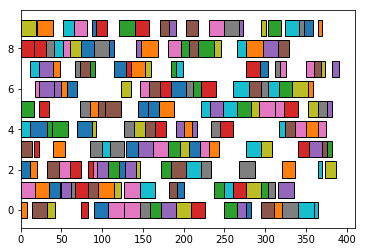

In [22]:
import numpy as np
import pandas as pd
import copy
import time
import math
import matplotlib.pyplot as plt


INF = 999999999
pt_exc = pd.read_excel("Job_dataset.xlsx" , sheet_name="Processing Time" , index_col = "Time")#index_col把某一個column設定成index
ms_exc = pd.read_excel("Job_dataset.xlsx" , sheet_name="Machines Sequence" , index_col = "order")
job_pri_due_exe = pd.read_excel("Job_dataset.xlsx" , sheet_name="Priority and Due Date" , index_col="order")

num_job = pt_exc.shape[0]
num_machine = pt_exc.shape[1]
num_gene = num_job * num_machine

#put the data into list
pt = [list( map(int,pt_exc.iloc[i])) for i in range(num_job)]
ms = [list( map(int,ms_exc.iloc[i])) for i in range(num_job)]
job_pri_due = [list( map( int , job_pri_due_exe.iloc[i])) for i in range(num_job)]  

best_list=[13, 18, 16, 13, 1, 7, 3, 0, 6, 14, 18, 4, 10, 7, 7, 8, 3, 2, 10, 9, 0, 8, 2, 2, 3, 18, 8, 1, 14, 12, 16, 3, 10, 14, 5, 4, 10, 17, 1, 13, 6, 18, 16, 14, 0, 7, 7, 15, 6, 2, 11, 12, 5, 14, 18, 15, 15, 3, 9, 0, 13, 1, 5, 17, 1, 16, 0, 12, 1, 1, 13, 10, 7, 12, 14, 9, 8, 16, 6, 16, 4, 12, 3, 10, 8, 13, 11, 1, 0, 11, 4, 5, 11, 2, 5, 18, 13, 6, 17, 16, 4, 7, 10, 3, 8, 6, 0, 8, 19, 10, 4, 10, 1, 9, 3, 16, 6, 11, 5, 5, 0, 14, 12, 14, 4, 9, 7, 12, 14, 18, 8, 15, 19, 15, 18, 19, 7, 18, 17, 9, 5, 5, 19, 17, 11, 7, 15, 0, 4, 8, 3, 2, 16, 13, 1, 15, 9, 15, 19, 11, 19, 12, 2, 6, 15, 19, 17, 5, 13, 16, 2, 10, 9, 6, 4, 12, 6, 19, 11, 12, 2, 18, 17, 17, 19, 11, 13, 14, 8, 0, 19, 15, 11, 4, 9, 17, 2, 9, 17, 3]



job_exe_time = { j:0 for j in range(num_job)}#dictionary to record job's own execute time
machine_exe_time = { j : 0 for j in range(num_machine)}#dictionary to record each machine execute time
job_operation = {j:0 for j in range(num_job)}#dictionary to record the job do which operation now
el_td={}#dictionary to record elariness and tardiness
#to caculate each chromosome
for job in best_list:
    #finish time
    this_processing_time = pt[job][job_operation[job]-1]
    this_machine_sequence = ms[job][job_operation[job]-1]-1
    color_str = 'C'+str(int(job/2))
    if job_exe_time[job] >= machine_exe_time[this_machine_sequence]:
        #plt.text(np.sum(T[:j + 1]) / 8, i, 'J%s\nT%s' % (J[j], T[j]), color="white", size=8)
        job_exe_time[job] += this_processing_time
        machine_exe_time[this_machine_sequence] = job_exe_time[job]
        plt.barh(this_machine_sequence, this_processing_time, left=machine_exe_time[this_machine_sequence]-this_processing_time,color=color_str,edgecolor='black')
    elif job_exe_time[job] < machine_exe_time[this_machine_sequence]:
        
        machine_exe_time[this_machine_sequence] += this_processing_time
        job_exe_time[job] = machine_exe_time[this_machine_sequence]
        plt.barh(this_machine_sequence, this_processing_time, left=machine_exe_time[this_machine_sequence]-this_processing_time,color=color_str,edgecolor='black')
    
    job_operation[job] = job_operation[job]+1
plt.show()
        